In [1]:
!pip install transformers datasets torch torchvision accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset

# Load the RSSCN7 dataset
dataset = load_dataset("blanchon/EuroSAT_RGB")

# Explore the dataset structure
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})


In [4]:
# Check the first example to see all available keys
example = dataset['train'][0]
print(example.keys())

# Print the first example to inspect its structure
print(example)

dict_keys(['image', 'label', 'filename'])
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64 at 0x7DEE3829F3A0>, 'label': 0, 'filename': 'AnnualCrop_1.tif'}


In [5]:
# Define label mapping
labels = dataset['train'].features['label'].names
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in id2label.items()}

# Print label mapping
print(id2label)

{0: 'Annual Crop', 1: 'Forest', 2: 'Herbaceous Vegetation', 3: 'Highway', 4: 'Industrial Buildings', 5: 'Pasture', 6: 'Permanent Crop', 7: 'Residential Buildings', 8: 'River', 9: 'SeaLake'}


In [6]:
from transformers import ViTImageProcessor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [7]:
# Step 4: Apply Transformations
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

def apply_test_transforms(examples):
    examples["pixel_values"] = [test_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transformations to the dataset
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [9]:
import torch
# Step 6: Batch Preparation
# Retrieve a batch from the training DataLoader
batch = next(iter(train_loader))

# Print the shape of data in the batch
print(f"Pixel values shape: {batch['pixel_values'].shape}")
print(f"Labels shape: {batch['labels'].shape}")

Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [10]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Calculate total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 85806346
Trainable parameters: 85806346


In [11]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TrainOutput(global_step=1620, training_loss=0.2767131463980969, metrics={'train_runtime': 690.7884, 'train_samples_per_second': 23.451, 'train_steps_per_second': 2.345, 'total_flos': 1.2554602436468736e+18, 'train_loss': 0.2767131463980969, 'epoch': 1.0})

In [14]:
# Assuming you have the trainer and test_ds already defined and trained

# Step 1: Get Predictions from the Test Set
outputs = trainer.predict(test_ds)
predictions = outputs.predictions.argmax(-1)
labels = outputs.label_ids

# Step 2: Compute Accuracy Manually
import numpy as np

accuracy = np.mean(predictions == labels)
print(f"Test accuracy: {accuracy:.2f}")


Test accuracy: 0.98


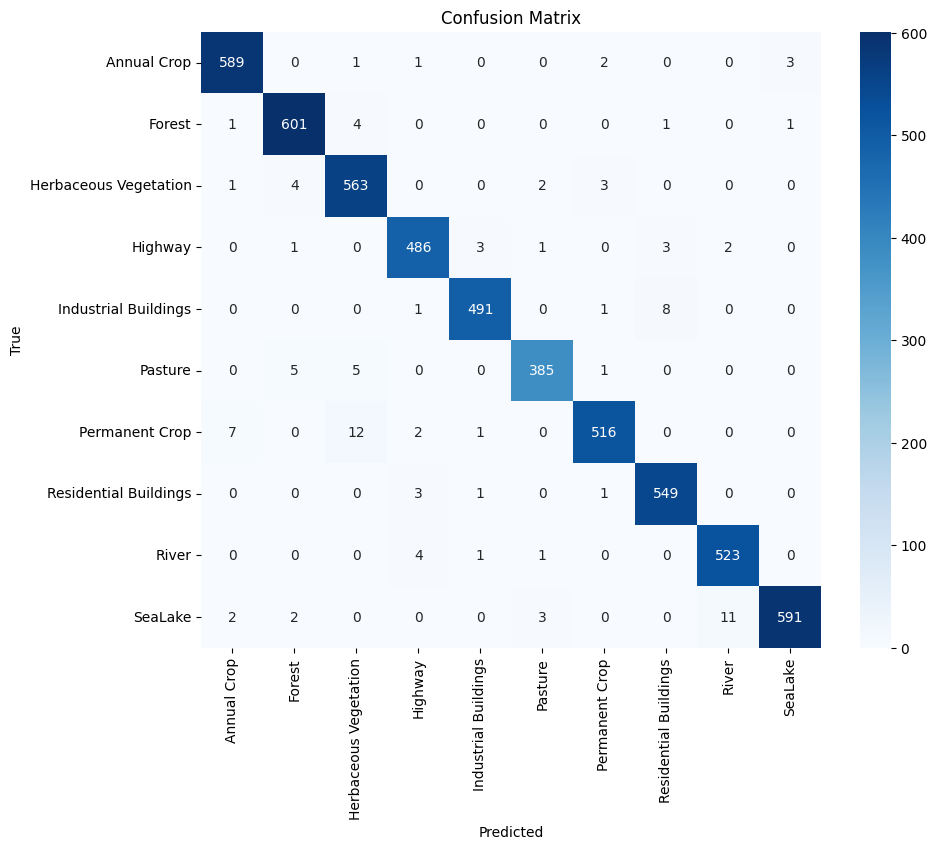

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Compute the Confusion Matrix
conf_matrix = confusion_matrix(labels, predictions)

# Step 3: Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
model.push_to_hub("vit_base_EUROSAT_98acc")

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rousian/vit_base_EUROSAT_98acc/commit/91caa3db2526a923fc1b0984c407f1b7dd711635', commit_message='Upload ViTForImageClassification', commit_description='', oid='91caa3db2526a923fc1b0984c407f1b7dd711635', pr_url=None, pr_revision=None, pr_num=None)